In [1]:
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.optimize import basinhopping
from sympy import Point, Line  
plt.rcParams.update({'mathtext.default':  'regular' })
plt.rcParams['font.family'] = 'Times'
plt.rcParams['font.size'] = 20
#from mlresearch.utils import set_matplotlib_style
#set_matplotlib_style(32, **{"font.family":"Times"})

### RecourseAwareClassifer

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class RecourseAwareClassifer(BaseEstimator, ClassifierMixin):
    def __init__(self, init_model, l = 100, niter=1):
        self.init_model = init_model
        self.l = l
        self.niter=niter

    def _sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def _getx0(self, X, y):
        self.init_model.fit(X, y)
        
        x0 = []
        x0.append(self.init_model.intercept_[0])
        x0.extend(list(self.init_model.coef_[0]))

        return x0

    def _getLoss(self, x, X, y, g):
        # Add column for intercept
        X = np.hstack((np.ones((X.shape[0],1)),X))
        
        linear_pred = np.dot(X,x)
        predictions = self._sigmoid(linear_pred)

        log_loss = np.sum(np.abs(y - predictions))

        # Group recourse difference

        # To get the distance from P3 perpendicular to a line drawn between P1 and P2
        c = -x[0]/x[2]
        m = -x[1]/x[2]

        p1=np.array([0,m*0 + c])
        p2=np.array([1,m*1 + c])

        avg_distances = []

        for group in np.unique(g):
            group_mask = g == group
            negative_class_mask = y == 0
            masks = group_mask & negative_class_mask

            total_distance = 0
            for x in (X[masks]):
                p3=np.array([x[1],x[2]])
                d=np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
                total_distance += d

            n = len(X[masks])
            avg_distances.append(total_distance / n)

        group_recourse_loss = abs(avg_distances[0] - avg_distances[1])

        loss = log_loss + self.l*group_recourse_loss
        
        return loss

    def fit(self, X, y, g):
        X, y = check_X_y(X, y)

        if X.shape[1] != 2:
            raise Exception("Only X matrices with 2 features are supported")

        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y

        f = lambda x: self._getLoss([x[0],x[1],x[2]],X,y,g)
        minimizer_kwargs = {"method":"BFGS", "jac":False}
        x0 = self._getx0(self.X_,self.y_)
        ret = basinhopping(f, x0, minimizer_kwargs=minimizer_kwargs, niter=2)

        self.w_ = ret.x
        self.intercept_ = np.array([list(ret.x)[0]])
        self.coef_ = np.array([list(ret.x)[1:]])

        return self

    def predict_proba(self):
        check_is_fitted(self)

        X = np.hstack((np.ones((self.X_.shape[0],1)),self.X_))
        linear_pred = np.dot(X,self.w_)
        
        return linear_pred

## Demo

### Data generation

In [3]:
mean = 0
std = 0.25
N_LOANS = 100
k = N_LOANS
N_AGENTS = 1000
n_agents = 1000
bias_factor=3

# Advantaged group
mu, sigma = mean+1.5, std
mu2, sigma2 = mean, std
high_perf = int((N_LOANS / (2*N_AGENTS)) * n_agents)
X1 = np.random.normal(mu, sigma, high_perf)
X2 = np.random.normal(mu2, sigma2, int((n_agents / 2) - high_perf))
f0 = np.concatenate([X1, X2])
f1 = np.random.normal(mean, std, int(n_agents/2))
X_adv = np.stack([f0, f1, np.zeros(int(n_agents/2))], axis=1)

# For disadvantaged group
mu, sigma = mean+1.5, std
mu2, sigma2 = mean - (bias_factor*std), std
high_perf = int((N_LOANS / (2*N_AGENTS)) * n_agents)
X1 = np.random.normal(mu, sigma, high_perf)
X2 = np.random.normal(mu2, sigma2, int((n_agents / 2) - high_perf))
f0 = np.concatenate([X1, X2])
f1 = np.random.normal(mean, std, int(n_agents/2))
X_disadv = np.stack([f0, f1, np.ones(int(n_agents/2))], axis=1)

X = pd.DataFrame(np.concatenate([X_adv, X_disadv]), columns=["f0", "f1", "groups"])

In [4]:
df = X.copy()

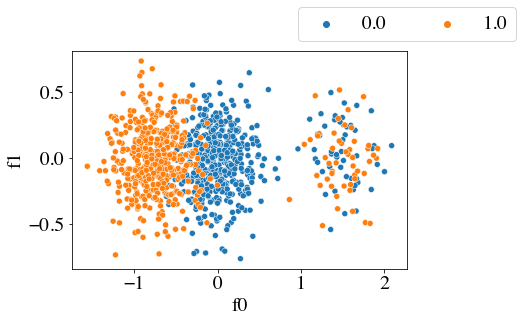

In [5]:
ax = sns.scatterplot(data=df, x="f0",y="f1",hue="groups")
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(1, 1), ncol=3, title=None, frameon=True,
)

### Create a label

In [6]:
df['score'] = df.apply(lambda row: 0.5 * row['f0'], axis=1)
df = df.sort_values(by=['score'],ascending=False)
threshold = df['score'].iloc[k-1]
df['selected'] = df['score'].apply(lambda x: 1 if x >= threshold else 0)

### Train RecourseAwareClassifier

In [7]:
X = df.filter(items=['f0','f1']).to_numpy()
y = df['selected'].to_numpy()
g = df['groups'].to_numpy()

# RecourseAwareClassifier takes a base classifier, a lambda value, and a number of iterations
# Note that the fit statement takes a numpy array g that contains group labels for all observations
#       (ex. g = array([0., 1., 1., 1., 2., 0.]))
clf = RecourseAwareClassifer(LogisticRegression(random_state=0), l=100, niter=100).fit(X,y,g)

<ipython-input-2-3e912713b482>:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
<ipython-input-2-3e912713b482>:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))
<ipython-input-2-3e912713b482>:12: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


In [8]:
clf.predict_proba()[-5:]

array([-72010.25928031, -68806.47004452, -65882.84649439, -70750.05882533,
       -73306.92250995])

In [9]:
clf.predict_proba()[0:5]

array([37486.72104474, 25440.25617958, 31689.73864226, 25668.56323065,
       27678.45487365])

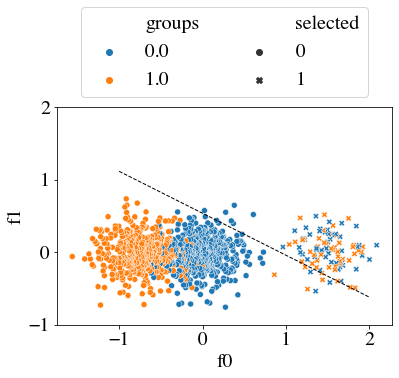

In [10]:
# Retrieve the model parameters
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary
xmin, xmax = -1, 2
ymin, ymax = -1, 2.5
xd = np.array([xmin, xmax])
yd = m*xd + c
ax = sns.scatterplot(data=df, x="f0",y="f1",hue="groups",style="selected")
ax.set(ylim=(-1, 2))
plt.plot(xd, yd, 'k', lw=1, ls='--')
sns.move_legend(
    ax, "lower center", bbox_to_anchor=(0.5, 1), ncol=2, title=None, frameon=True,
)